<a href="https://colab.research.google.com/github/BBVA/mercury-explainability/blob/fix%2Ftutorials_execution/tutorials/BasicTutorial_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial mercury-explainability

This tutorial shows the use of mercury-explainability to obtain explanations from models. Concretely, it uses two models from two different frameworks: one from sklearn and another from PySpark. We will some of the different explainers available in the library

## Setup

You need to install mercury-explainability to run this tutorial. Furthermore, the tutorial uses pyspark and alibi, so if you don't have them installed you need to install them as well. You can un the next command in a cell to install these libraries:
```
!pip install mercury.explainability alibi pyspark
```

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import ensemble
from matplotlib import pyplot as plt
%matplotlib inline

import pyspark

import sklearn.ensemble
from pyspark.sql import SparkSession
from pyspark.ml.classification import GBTClassificationModel, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

## Load Dataset

We will use the Iris Dataset

In [ ]:
iris = datasets.load_iris()

predictors = pd.DataFrame(iris.data, columns=iris.feature_names)
target = iris.target

full_df = pd.DataFrame(iris.data, columns=iris.feature_names)
full_df['label'] = target

## Train Models

First, we train a Random Forest with **sklearn**

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=500, random_state=30)
rf = rf.fit(iris.data, iris.target)

We also train a Random Forest with  **PySpark**

In [ ]:
spark = SparkSession.builder.appName("Mercury Example").getOrCreate()

spark_dataset = spark.createDataFrame(full_df)
vectAssembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
spark_dataset = vectAssembler.transform(spark_dataset)

rf_predictor = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model = rf_predictor.fit(spark_dataset)

## CounterFactualBasic

Let's try the first explainer: the **CounterFactualBasic**, which provides CounterFactual explanations. Let's instantiate it.

In [ ]:
from mercury.explainability import CounterFactualExplainerBasic

In [ ]:
counterfactual_basic = CounterFactualExplainerBasic(
    predictors,
    rf.predict_proba  # Model prediction function which returns class distribution probabilities
)

Now we call the `explain` method. The first parameter is the instance that we want to explain. The second and third parameters, `threshold` and `class_idx`, indicate that for this instance we want to know which changes in the features we can make in order to achieve a probability of 0.9 for class 2.  There are other parameters that you can use to tune the explanation. You can check the documntation for more details.

In [ ]:
explanation = counterfactual_basic.explain(predictors.head(1).values.flatten(),
                                           threshold=.9,
                                           class_idx=2,
                                           step=np.array([.1] * 4))

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


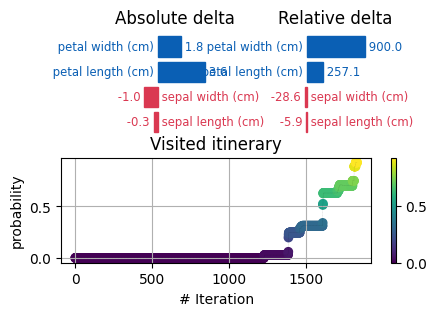

In [ ]:
explanation.show(figsize=(5, 3))

As we see, by considerably increasing the petal width and petal length, and decreasing the sepal width and length the probability of this instance to belong to class 0.9 would increase from 0 to 0.9

Now, we will do the same for the PySpark model. In this case, we need to use the **SparkWrapper** class.


In [ ]:
from mercury.explainability.pyspark_utils import SparkWrapper

In [ ]:
model_w = SparkWrapper(
    model,
    iris.feature_names,
    spark_session=spark,
    # If we have a different name for the input and output columns, we need to specify it
    model_inp_name="features",
    model_out_name="probability",
)

Now, let's create the explanations in a similar way as we did it for the scikit learn model:


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


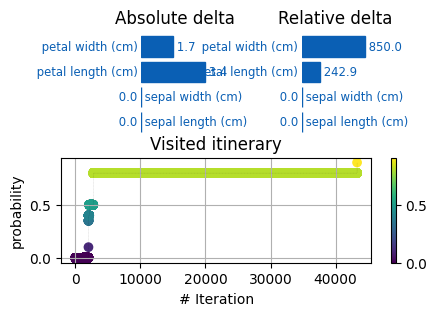

In [ ]:
counterfactual_basic = CounterFactualExplainerBasic(
    predictors,
    model_w
)

explanation = counterfactual_basic.explain(predictors.head(1).values.flatten(),
                                           threshold=.9,
                                           class_idx=2,
                                           step=np.array([.1] * 4))
explanation.show(figsize=(5, 3))

**Note: the next explainers can be used with PySpark models in a similar way, but for simplification we will show only the scikit version**


## CounterFactualProto

Next, we will use the `CounterFactualProtoExplainer`, which creates explanations guided by prototypes.

This explainer extends the one implemented in Alibi. You can read its documentation to understand the extra parameters:

https://docs.seldon.io/projects/alibi/en/stable/methods/CF.html?highlight=explanation#Counterfactual-Instances

<div class="alert alert-warning">
Note: in order to make the CounterfactualProtoExplainer with modern versions of tensorflow it might be necessary to disable the eager executation, which can be done by executing:

</div>

```python
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
```

In [ ]:
from mercury.explainability import CounterfactualProtoExplainer

In [ ]:
cfExplainer = CounterfactualProtoExplainer(
    predict_fn=rf.predict_proba,
    train_data=predictors,
    theta=10,
    max_iterations=200,
    eps=(5e-2, 5e-2),
    feature_range=(-10,10)
)

The class name `CounterFactualProto` is deprecated, please use `CounterfactualProto`.


In [ ]:
cf_explanation = cfExplainer.explain(predictors.head(1).values)

The explanation obtained is a dictionary. You can read more information [here](https://docs.seldon.io/projects/alibi/en/stable/methods/CF.html?highlight=explanation#Explanation), but some useful information is:

- `orig_class`: predicted class for original instance
- `orig_proba`: predicted class probabilities for original instance
- `cf['X']`: the counterfactual instance
- `cf['class']`: predicted class for the counterfactual
- `cf['proba']`: predicted class probabilities for the counterfactual



In [ ]:
print("Original instance predicted class: ", cf_explanation.orig_class)
print("Original instance predicted probabilities: ", cf_explanation.orig_proba)


print("Counterfactual instance: ", cf_explanation.cf['X'])
print("Counterfactual instance predicted class: ", cf_explanation.cf['class'])
print("Counterfactual instance predicted probabilites: ", cf_explanation.cf['proba'])


Original instance predicted class:  0
Original instance predicted probabilities:  [[1. 0. 0.]]
Counterfactual instance:  [[5.1       2.6098661 2.6129415 0.5198966]]
Counterfactual instance predicted class:  1
Counterfactual instance predicted probabilites:  [[0.498 0.502 0.   ]]




A particularlity of this explainer is that it adds a method to obtain the importance of the features for the model.

In [ ]:
%time
cfExplainer.get_feature_importance(predictors.head(5))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs

                There's been a problem while computing the explanation for observation: 2.
                If this observation is critical to you try with some other hyperparameters.
                

                There's been a problem while computing the explanation for observation: 3.
                If this observation is critical to you try with some other hyperparameters.
                
5 counterfactuals already computed. Found a solution for 3 of them
All counterfactuals have been computed and regularized
There were a total of 2 fails
The 3 most important features and their importance values according to the first metric (amount features change) are: 
    petal width (cm) 1.00 -1.00 AND petal length (cm) 0.48 -1.00 AND sepal length (cm) 0.41 -1.00.

According to the second metric (times features change), these importances are: 
    petal width (cm) 1.00 AND sepal length (cm) 0.33 AND sepal width (cm) 0.33


## AnchorsExplainer

Now, let's use the `AnchorsWithImportanceExplainer`. This method explains individual predictions of the models by finding a rule (anchor) where the prediction of the model is the same even changing the values of the rest of the features.

Let's see an example:

In [ ]:
from mercury.explainability import AnchorsWithImportanceExplainer

In [ ]:
anchorsExplainer = AnchorsWithImportanceExplainer(
    predict_fn=rf.predict_proba,
    train_data=predictors
)

In [ ]:
anchor_explanation = anchorsExplainer.explain(predictors.head(1).values)

In [ ]:
print("prediction: ", anchor_explanation.data['raw']['prediction'])
print("anchor: ", anchor_explanation.data['anchor'])
print("precision: ", anchor_explanation.data['precision']) # fraction of times the sampled instances the anchor holds with the same prediction
print("coverage: ", anchor_explanation.data['coverage']) #the fraction of sampled instances the anchor applies to.

prediction:  [0]
anchor:  ['petal length (cm) <= 1.60', 'petal width (cm) <= 0.30']
precision:  1.0
coverage:  0.2561


We observe that the anchor found is: when the feature "petal width" <= 0.30 and the feature "petal length" <= 1.60 our model predicts the class 0 100% (precision=1) of the times when that occurs in our dataset. This covers 26.26% of the cases of that class. We can use the method `translate` to obtain an intuitive explanation:

In [ ]:
anchorsExplainer.translate(anchor_explanation)

'[GOOD explanation] This anchor explains a 25.61% of all records of its class with 100.0% confidence.'

We can also use the `get_feature_importance` method to explain the most important features when explaining the predictions of a dataset:

In [ ]:
explanation = anchorsExplainer.get_feature_importance(explain_data=predictors.head(20))

In [ ]:
explanation.interpret_explanations(n_important_features=2);

The 2 most common features are: petal length (cm) <= with a frequency of 19 (95.0%) petal width (cm) <= with a frequency of 18 (90.0%) 


## ALE Explainer (+ ALE plots)

Accumulated Local Effects (ALE) is a method to calculate the global effects of the features. The method is similar to the Partial Dependence Plots (PDP) and tries to correct some of the problems of that method.

The Partial Dependence Plots might not be adequate when there are strong correlations between features. This happens because during its calculation they can generate synthetic instances that are very difficult (or impossible) to exist. The ALE plots try to solve this problem by measuring **the change** in the predictions instead of measuring just the predictions. Moreover, the ALE plots are faster to calculate than PDP.

For more details you can read [here](https://christophm.github.io/interpretable-ml-book/ale.html)


In mercury.explainability, the method is implemented in the `ALEExplainer` class:


In [ ]:
from mercury.explainability import ALEExplainer

In [ ]:
ale = ALEExplainer(rf.predict_proba,
                   target_names=list(iris.target_names)  # Para que la explicacion incluya el nombre de las clases
)

In [ ]:
exp = ale.explain(predictors)

Once we obtained the explanation, we can import the `plot_ale` function to show the ALE plots:

In [ ]:
from mercury.explainability.explainers.ale import plot_ale

array([[<Axes: xlabel='sepal length (cm)', ylabel='ALE'>,
        <Axes: xlabel='sepal width (cm)', ylabel='ALE'>],
       [<Axes: xlabel='petal length (cm)', ylabel='ALE'>,
        <Axes: xlabel='petal width (cm)', ylabel='ALE'>]], dtype=object)

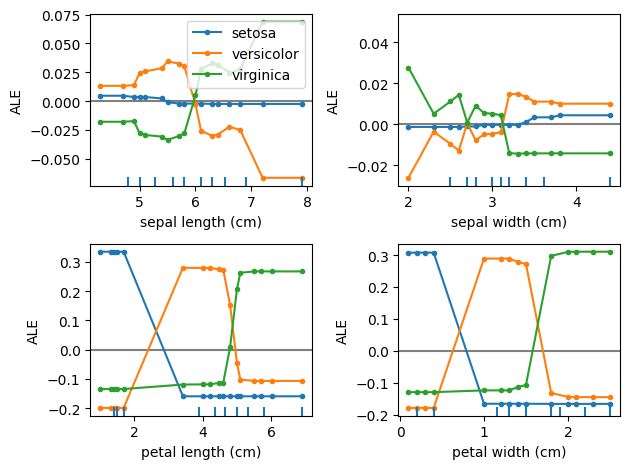

In [ ]:
plot_ale(exp, n_cols=2, sharey=None, targets=[0,1,2])

The ALE plots show the effect of a feature when that feature has a certain value compared with the average prediction. We can see an example in the previous figure. For feature "petal length" (bottom left corner) having a small value makes that the average prediction to belong to "setosa" class increase by more than 0.3. In contrast, for values higher than 3.5 the average prediction to belong to that class decreases.